# Problem 2a

The potential in the branching step can diverge, causing the number of walkers to go extreme. In contrast, using importance sampling DMC, the potential is replaced by a local energy. Therefore, the branching step is more stable.

# Problem 2b

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [84]:
M = 300 #number of random walkers
R = np.zeros((2*M,3))
for m in range(2*M):
    for d in range(3):
        R[m,d] = np.random.uniform(-0.5, 0.5)    

In [85]:
dt = 0.03
dt_p = 1
N_equilibrium = 10000
N = 30000 + N_equilibrium
N_adjust = 1
kappa = 2 
beta = 1/2
alpha = 0.18
E_0 = -2.90338583

In [86]:
def energy_local(vec_r_1, vec_r_2, alpha, beta, kappa):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_1 - vec_r_2
    r_12 = np.linalg.norm(vec_r12)
    u = 1+alpha*r_12
    scalar_product = np.dot((vec_r_1/r_1) - (vec_r_2/r_2), vec_r12/r_12)
    
    term_1 = (kappa-2)/r_1
    term_2 = (kappa-2)/r_2
    term_3 = (1-2*beta/u**2)/r_12
    term_4 = 2*beta*alpha/u**3
    term_5 = -kappa**2
    term_6 = -(beta**2)/u**4
    term_7 = (kappa*beta/u**2)*scalar_product
    E_L =  term_1 + term_2 + term_3 + term_4 + term_5 + term_6 + term_7    
    return E_L

def psi_T(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_1 - vec_r_2
    r_12 = np.linalg.norm(vec_r12)
    pref = beta*r_12/(1+alpha*r_12)
    psi = np.exp(-kappa*r_1)*np.exp(-kappa*r_2)*np.exp(pref)
    return psi

def Fokker_planck(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    #r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    u = 1 + alpha*r_12
    factor = beta*(((u/r_12)-alpha)/u**2)
    force_1 = 2*(-kappa*(vec_r_1/r_1)+factor*(vec_r_1-vec_r_2))
    #force_2 = 2*(-kappa*(vec_r_2/r_2)+factor*(vec_r_2-vec_r_1))
    return np.array(force_1)

def greens_function(vec_r_try_1, vec_r_try_2, vec_r_old_1, vec_r_old_2, alpha, beta, kappa, delta_t):    
    f_try_1 = Fokker_planck(vec_r_try_1, vec_r_try_2, alpha, kappa, beta)
    f_old_1 = Fokker_planck(vec_r_old_1, vec_r_old_2, alpha, kappa, beta)
    f_try_2 = Fokker_planck(vec_r_try_2, vec_r_try_1, alpha, kappa, beta)
    f_old_2 = Fokker_planck(vec_r_old_2, vec_r_old_1, alpha, kappa, beta)
    
    c_try_1 = np.linalg.norm(vec_r_try_1 - vec_r_old_1 + f_try_1*delta_t/2)**2
    c_try_2 = np.linalg.norm(vec_r_try_2 + vec_r_old_2 - f_try_2*delta_t/2)**2
    c_old_1 = np.linalg.norm(vec_r_old_1 - vec_r_try_1 + f_old_1*delta_t/2)**2
    c_old_2 = np.linalg.norm(vec_r_old_2 + vec_r_try_2 - f_old_2*delta_t/2)**2
    
    c = +c_try_1+c_try_2-c_old_1-c_old_2
    pref = (1/np.sqrt(2*np.pi*delta_t)) #Should cancel out
    return np.exp(-c/2*delta_t)

def DMC_algorithm(initial_state, num_trials, s, alpha, beta, kappa, n_adjust, delta_t, e_0, disable_tqdm = False):
    sequence_states = [initial_state]
    list_e_t = []
    e_t = e_0
    for step in tqdm(range(num_trials), disable=disable_tqdm):
        if step%n_adjust == 0:
            m_current = sequence_states[-1].shape[0]/2
            e_t = e_0 + np.log(0.5*initial_state.shape[0]/m_current)
            list_e_t.append(e_t)
        next_sequence = DMC_step(sequence_states[-1], alpha, beta, s, kappa, delta_t, e_t)
        sequence_states.append(next_sequence)
    return sequence_states, np.array(list_e_t)
   
def branching_step(r_accepted, r_2_accepted, delta_t, alpha, beta, kappa, e_t):
    v = energy_local(r_accepted, r_2_accepted, alpha, beta, kappa)
    energy_diff = v - e_t
    q = np.exp(-delta_t*energy_diff)
    rand = np.random.rand()
    if q > 1:
        #walker gives birth
        multiplicity = np.floor(q+rand)
    else:
        if rand < q:
            #walker survives
            multiplicity = 1
        else: 
            #walker dies
            multiplicity = 0
    return int(multiplicity)
   
def DMC_step(current_state, alpha, beta, s, kappa, delta_t, e_t):
    trial_configuration = current_state.copy()
    m_now = int(trial_configuration.shape[0]/2)
    new_state_walker1 = []
    new_state_walker2 = []
    for i in range(m_now):
        trial_configuration[i] += Fokker_planck(current_state[i], current_state[i+m_now], alpha, kappa, beta)*delta_t/2
        trial_configuration[i+m_now] += Fokker_planck(current_state[i+m_now], current_state[i], alpha, kappa, beta)*delta_t/2
        trial_configuration[i] += np.random.normal(0,1,3)*np.sqrt(delta_t)
        trial_configuration[i+m_now] += np.random.normal(0,1,3)*np.sqrt(delta_t)
        p = (psi_T(trial_configuration[i], trial_configuration[i+m_now], alpha, kappa, beta)/psi_T(current_state[i], current_state[i+m_now], alpha, kappa, beta))**2
        g = greens_function(trial_configuration[i], trial_configuration[i+m_now], current_state[i], current_state[i+m_now], alpha, beta, kappa, delta_t)
        p *= g                   
        trial_acceptance_prob = np.min([1, p])
        r_accept = np.random.rand()
        if r_accept < trial_acceptance_prob:
            multiplicity = branching_step(trial_configuration[i], trial_configuration[i+m_now], delta_t, alpha, beta, kappa, e_t)
            for _ in range(multiplicity):
                new_state_walker1.append(trial_configuration[i])
                new_state_walker2.append(trial_configuration[i+m_now])
        else:
            new_state_walker1.append(current_state[i])
            new_state_walker2.append(current_state[i+m_now])
    new_state_walker1 = np.array(new_state_walker1)
    new_state_walker2 = np.array(new_state_walker2)
    new_state = np.concatenate((new_state_walker1, new_state_walker2), axis=0)
    return new_state

In [87]:
sim, energies = DMC_algorithm(R, N, N_adjust, alpha, beta, kappa, 1, dt, E_0)

100%|██████████| 40000/40000 [21:22<00:00, 31.18it/s]


Text(0.5, 0, 'simulation step')

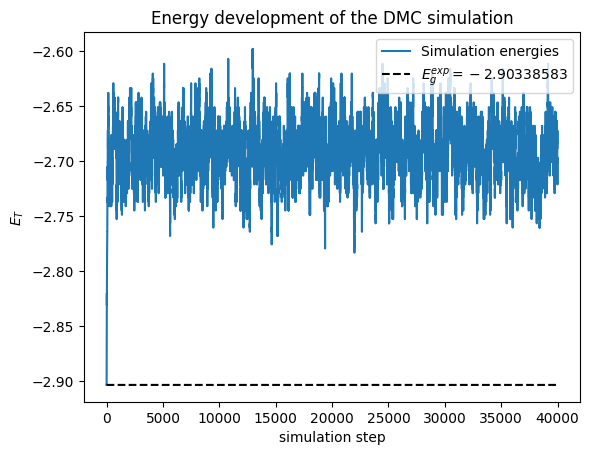

In [88]:
arange_N = np.arange(N)

plt.plot(arange_N, energies, label = "Simulation energies")
plt.plot(arange_N, np.ones(N)*E_0, "k--", label = "$E_{g}^{exp} = −2.90338583$")
plt.title("Energy development of the DMC simulation")
plt.legend()
plt.ylabel("$E_{T}$")
plt.xlabel("simulation step")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$M_{t}$')

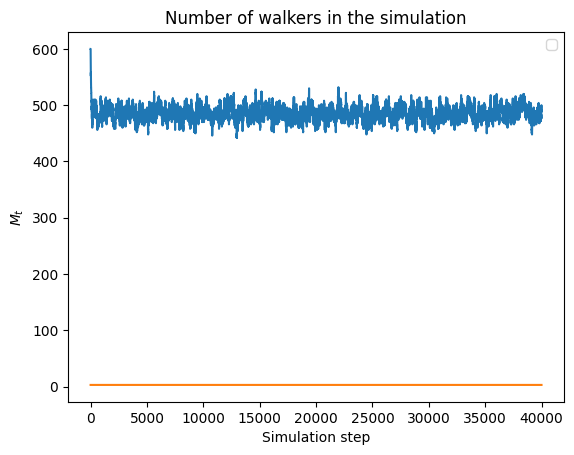

In [96]:
N_walkers = []

for timestep in range(N):
    n_walker = sim[timestep].shape
    N_walkers.append(n_walker)
    
plt.plot(arange_N, N_walkers)
plt.title("Number of walkers in the simulation")
plt.xlabel("Simulation step")
plt.ylabel("$M_{t}$")

The simulation energies fluctuate strongly around a value around $E \approx -0.70$. This deviates strongly from the experimental value. However, the number of walkers does not increase, so the particles don't multiply too much (the guide function works). Therefore, I expect the problem to be in the greens function or the wave function, which form the transition probability. It is likely that the error is systematic, because the energy finds an equilibrium value. The order of magnitude of that value and the correct value is the same, thus the error shouldn't be too critical for the simulation (e.g. maybe somewhere is a wrong sign for a term).

# Problem c 

Text(0, 0.5, 'Frequency')

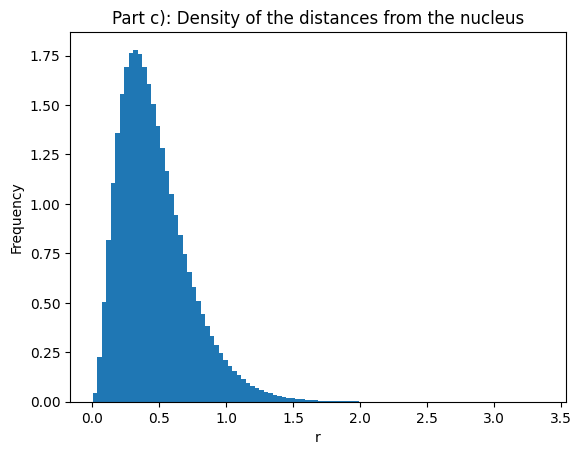

In [91]:
dists = []

for time in range(N_equilibrium, N):
    for i in range(sim[time].shape[0]):
        l = np.linalg.norm(sim[time][i])
        dists.append(l)
        
hist = plt.hist(dists, bins=100, density=True)
plt.title("Part c): Density of the distances from the nucleus")
plt.xlabel("r")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

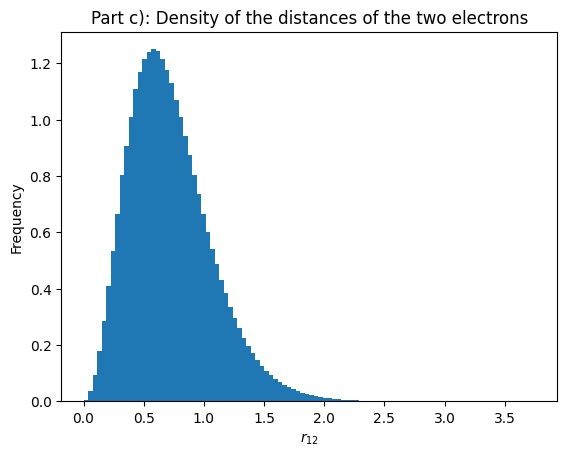

In [92]:
dists_electrons = []

for time in range(N_equilibrium, N):
    m_current = int(sim[time].shape[0]/2)
    for i in range(m_current):
        l = np.linalg.norm(sim[time][i]-sim[time][i+m_current])
        dists_electrons.append(l)
        
hist = plt.hist(dists_electrons, bins=100, density=True)
plt.title("Part c): Density of the distances of the two electrons")
plt.xlabel("$r_{12}$")
plt.ylabel("Frequency")

The distributions again mirror the fact that there is a fixed radius to the nucleus that corresponds to a minimal energy. Unlike in the FP-VMC, the densities occur not (only) due to a shift of the walkers, but through multiplicity of walkers that are close to the optimal energy/radius. Walkers with a position far off that optimal value are likely to be killed in the branching step.